In [ ]:
# Useful imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
import torchvision.models
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/APS360_Project/Mushaugm2.zip -d /root/Mushaugm2
!unzip /content/drive/MyDrive/APS360_Project/Mush_val.zip -d /root/Mush_val
!unzip /content/drive/MyDrive/APS360_Project/Mush_test.zip -d /root/Mush_test

Archive:  /content/drive/MyDrive/APS360_Project/Mushaugm2.zip
replace /root/Mushaugm2/Entoloma/image_1002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/APS360_Project/Mush_val.zip
replace /root/Mush_val/Agaricus/image_1010.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/APS360_Project/Mush_test.zip
replace /root/Mush_test/Agaricus/image_111.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Pytorch seed for reproducable results
torch.manual_seed(1000)
torch.set_deterministic(True)

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


In [ ]:
# Get dataloader for the train, validation, and test set
def get_data_loader(batch_size):
    # Normalize images to the range [-1, 1]
    transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load Dataset
    # Load Dataset
    # path = '/root/Mushfixs'
    # dataset = torchvision.datasets.ImageFolder(path, transform=transform)
    dataset_train = torchvision.datasets.ImageFolder('/root/Mushaugm2', transform=transform)
    dataset_val = torchvision.datasets.ImageFolder('/root/Mush_val', transform=transform)
    dataset_test = torchvision.datasets.ImageFolder('/root/Mush_test', transform=transform)
    
    # # Split into train, validation, and test sets
    # num_images = len(dataset)
    # train_len, val_len = int(0.7 * num_images), int(0.2 * num_images)
    # test_len = num_images - train_len - val_len

    # train_data, val_data, test_data = random_split(
    #     dataset,
    #     [train_len, val_len, test_len],
    #     generator=torch.Generator()
    # )
    
    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader, test_loader

In [ ]:
# Verify that the dataloader works
#train_loader, val_loader, test_loader = get_data_loader(batch_size = 1)

In [ ]:
# Download a pretrained ResNet-152 net model
ResNet = torchvision.models.resnet152(pretrained=True, progress=False)
modules = list(ResNet.children())[:-1] # delete the last fc layer.
#num_ftrs = ResNet.fc.in_features

ResNetCL = nn.Sequential(*modules)
## Now set requires_grad to false
# for param in ResNetCL.parameters():
#     param.requires_grad = False

In [ ]:
# check the dimension of the output of
# test, labels = next(iter(train_loader))
# print(test.shape)
# test = ResNetCL(test)
# print(test.shape)

In [ ]:
# Fully connected model
class ClassyMush(nn.Module):
    def __init__(self):
        super(ClassyMush, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 9)

    def forward(self, x):
        x = x.view(-1, 2048*1*1) #flatten feature data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1)
        return x

In [ ]:
# Define training and accuracy functions
def get_accuracy(model, cnn_model, loader):
  
    correct = 0
    total = 0
    for imgs, labels in loader:
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(cnn_model(imgs))
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        if use_cuda and torch.cuda.is_available():
            imgs.to('cpu')
            labels.to('cpu')



    return correct / total

# Calculate the accuracy quikly during training
def quick_accuracy(model, cnn_model, loader):
  imgs, labels = next(iter(loader))
  
  #############################################
  #To Enable GPU Usage
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  #############################################

  output = model(cnn_model(imgs))
  
  #select index with maximum prediction score
  pred = output.max(1, keepdim=True)[1]
  correct = pred.eq(labels.view_as(pred)).sum().item()
  total = imgs.shape[0]
  
  if use_cuda and torch.cuda.is_available():
    imgs.to('cpu')
    labels.to('cpu')

  # Only take the first batch for an accuracy approximation
  return correct / total

def get_model_name(batch_size, learning_rate, num_epochs):
    path = "ResNet_bs{}_lr{}_ne{}".format(batch_size, learning_rate, num_epochs)
    return path

def train_net(train_loader, val_loader, net, cnn_model, batch_size=64, learning_rate=0.01, num_epochs=30, save_after=100):
    # Cross Entropy loss criterion
    criterion = nn.CrossEntropyLoss()

    # Stochastic Gradient Descent
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    # Use lists to track accuracy and loss
    iters, losses, train_acc, val_acc = [], [], [], []


    # Highest Validation accuracy for saving
    max_acc = 0
    save_path = "/content/drive/MyDrive/APS360_Project/resnet152_states/Alexis/unfreeze/"
    model_path = get_model_name(batch_size, learning_rate, num_epochs)
    model_path = save_path + model_path


    # training
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for images, labels in iter(train_loader):
            
            if use_cuda and torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            mid = cnn_model(images).detach()
            

            out = net(mid)                      # forward pass
            loss = criterion(out, labels)       # compute the total loss
            loss.backward()                     # backward pass (compute parameter updates)
            optimizer.step()                    # make the updates for each parameter
            optimizer.zero_grad()               # a clean up step for PyTorch

            ### save the current training information ###
            # only save every few iterations
            if n % 3 == 0:

                # Iteration index
                iters.append(n)

                # average loss
                losses.append(float(loss)/batch_size)

                # compute quick validation accuracy
                val_acc.append(quick_accuracy(net, cnn_model, val_loader))
                
                # compute quick training accuracy 
                pred = out.max(1, keepdim=True)[1]
                correct = pred.eq(labels.view_as(pred)).sum().item()
                total = images.shape[0]
                train_acc.append(correct / total)
                #print("Iteration:", n)
            
            n += 1
            #print("Iteration:", n)


            # move everything back to cpu 
            if use_cuda and torch.cuda.is_available():
                images = images.to('cpu')
                labels = labels.to('cpu')

            #######################################################
            # Only save if improved, but after 200 iterations because in the beginning it will always save
            if val_acc[-1] > max_acc and n > save_after:
                print("Found better, saving at epoch {} | iter {} - Validation accuracy: {:.2f}%".format(epoch+1, n+1, val_acc[-1]*100))
                max_acc = val_acc[-1]
                
                # Save the current model (checkpoint) to a file
                torch.save(net.state_dict(), model_path + ".pt")
                torch.save(cnn_model.state_dict(), model_path + "_ResNet.pt")
                ############################################


        print(("Epoch {} Iter {}: Train acc: {} |"+
                " Validation acc: {} | loss: {}").format(epoch + 1, n + 1,
                train_acc[-1], val_acc[-1], losses[-1]))
        

    # Load and save state!
    net.load_state_dict(torch.load(model_path + ".pt"))
    cnn_model.load_state_dict(torch.load(model_path + "_ResNet.pt"))

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    # Write the train/val err and loss into CSV file for plotting later
    np.savetxt("{}_data.csv".format(model_path), [iters, losses,
                                                  train_acc, val_acc])

    return cnn_model, net

def plot_training_curve(path):
    iters, losses, train_acc, val_acc = np.loadtxt("{}_data.csv".format(path))
    
    # plotting
    plt.subplot(1, 2, 1)
    plt.title("Loss Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# Initialize model
use_cuda = True;
if use_cuda and torch.cuda.is_available():
    print("Selecting GPU...")
    net = ClassyMush().cuda()
    modules = list(ResNet.children())[:-1] # delete the last fc layer.
    ResNetCL = nn.Sequential(*modules)
    ResNetCL = ResNetCL.cuda()
    #print(ResNetCL.type)
    ### Now set requires_grad to false
    ct = 0
    for param in ResNetCL.parameters():
        ct += 1
        if ct < 140:
          param.requires_grad = False

else:
    net = ClassyMush()
    modules = list(ResNet.children())[:-1] # delete the last fc layer.
    ResNetCL = nn.Sequential(*modules)
    ### Now set requires_grad to false
    ct = 0
    for param in ResNetCL.parameters():
        ct += 1
        if ct < 140:
          param.requires_grad = False


Selecting GPU...


In [ ]:
# Train the model
#def          train_net(net, cnn_model, batch_size=64, learning_rate=0.01, num_epochs=30)
bs = 128
lr = 0.001
ne = 100
sa = 50

# Get loaders for the training, validation, and test sets
train_loader, val_loader, test_loader = get_data_loader(bs)


NewResNetCL, NewNet = train_net(train_loader, val_loader, net, ResNetCL, batch_size=bs, learning_rate=lr, num_epochs=ne, save_after=sa)

Found better, saving at epoch 1 | iter 52 - Validation accuracy: 21.09%
Found better, saving at epoch 1 | iter 56 - Validation accuracy: 25.00%
Found better, saving at epoch 1 | iter 62 - Validation accuracy: 28.12%
Found better, saving at epoch 1 | iter 65 - Validation accuracy: 29.69%
Found better, saving at epoch 1 | iter 68 - Validation accuracy: 32.81%
Found better, saving at epoch 1 | iter 71 - Validation accuracy: 39.84%
Found better, saving at epoch 1 | iter 104 - Validation accuracy: 42.97%
Found better, saving at epoch 1 | iter 134 - Validation accuracy: 43.75%
Epoch 1 Iter 142: Train acc: 0.34375 | Validation acc: 0.3359375 | loss: 0.016681447625160217
Found better, saving at epoch 2 | iter 152 - Validation accuracy: 45.31%
Found better, saving at epoch 2 | iter 164 - Validation accuracy: 48.44%
Found better, saving at epoch 2 | iter 194 - Validation accuracy: 54.69%
Found better, saving at epoch 2 | iter 269 - Validation accuracy: 56.25%
Epoch 2 Iter 283: Train acc: 0.48437

In [ ]:
#bs=128
#lr = 0.0005
#ne = 50

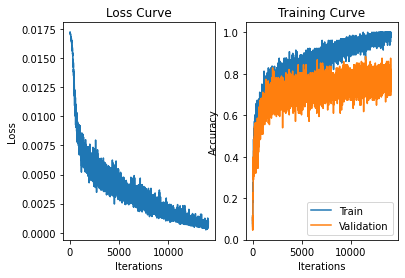

In [ ]:
save_path = "/content/drive/MyDrive/APS360_Project/resnet152_states/Alexis/unfreeze/"
path = get_model_name(bs, lr, ne)
plot_training_curve(save_path + path)

In [ ]:
NewNet.cuda()
NewResNetCL.cuda()

NewResNetCL.eval()
NewNet.eval()

ClassyMush(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=9, bias=True)
)

In [ ]:
# Test accuracy
save_path = "/content/drive/MyDrive/APS360_Project/resnet152_states/Alexis/unfreeze/"
model_path = get_model_name(bs, lr, ne)
model_path = save_path + model_path
NewNet.load_state_dict(torch.load(model_path + ".pt")) 
print("loaded")

train_loader, val_loader, test_loader = get_data_loader(1)

NewNet.cuda()
NewResNetCL.cuda()

NewResNetCL.eval()
NewNet.eval()

print('Finished Training')
print('Final accuracy: training: {:.2f} | validation: {:.2f}'.format(
    get_accuracy(NewNet, NewResNetCL, train_loader),
    get_accuracy(NewNet, NewResNetCL, val_loader)
))
get_accuracy(NewNet, ResNetCL, val_loader)



loaded
Finished Training
Final accuracy: training: 0.92 | validation: 0.78


0.7797752808988764

In [ ]:
ResNetCL.cpu()
net.cpu()
torch.cuda.empty_cache()